# Classical Machine Learning for Activity Recognition

This notebook trains and evaluates classical ML models:
- Random Forest
- XGBoost

We compare performance using cross-validation and comprehensive metrics.

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Add src to path
sys.path.insert(0, str(Path("../src").resolve()))

from fittrack.data.ingestion import HARDataLoader, ACTIVITY_LABELS
from fittrack.data.preprocessing import (
    create_train_val_test_split,
    get_class_weights,
    get_sample_weights,
)
from fittrack.models.classical import (
    ModelConfig,
    train_random_forest,
    train_xgboost,
    train_with_tuning,
    cross_validate_model,
    get_top_features,
    ClassicalModelTrainer,
)
from fittrack.models.evaluation import (
    compute_metrics,
    plot_confusion_matrix,
    plot_roc_curves,
    plot_precision_recall_per_class,
    plot_model_comparison,
    print_classification_report,
    ModelEvaluator,
)

plt.style.use("seaborn-v0_8-whitegrid")
%matplotlib inline

# Determine project root (works whether run from notebooks/ or fittrack-ml/)
_cwd = Path.cwd()
PROJECT_ROOT = _cwd.parent if _cwd.name == "notebooks" else _cwd
FIGURES_DIR = PROJECT_ROOT / "docs" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

/Users/deo/opt/anaconda3/envs/ds_main/lib/python3.11/site-packages/pandera/_pandas_deprecated.py:157: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


## 1. Load and Preprocess Data

In [2]:
# Load data
loader = HARDataLoader()
train_data, test_data = loader.load_all()

print(f"Training samples: {train_data.n_samples}")
print(f"Test samples: {test_data.n_samples}")
print(f"Features: {train_data.n_features}")
print(f"Classes: {train_data.n_classes}")

Training samples: 7352
Test samples: 2947
Features: 561
Classes: 6


In [3]:
# Create train/val/test split from training data
# (The original test set is held out for final evaluation)
split = create_train_val_test_split(
    train_data.X,
    train_data.y,
    val_size=0.15,
    test_size=0.15,
    normalize=True,
)

# Normalize the held-out test set using the same scaler
X_test = split.scaler.transform(test_data.X.values)
y_test = split.label_encoder.transform(test_data.y["activity"])

print(f"\nSplit sizes:")
print(f"  Train: {len(split.X_train)}")
print(f"  Validation: {len(split.X_val)}")
print(f"  Test (held out): {len(X_test)}")


Split sizes:
  Train: 5146
  Validation: 1103
  Test (held out): 2947


In [4]:
# Class names and weights
class_names = split.class_names
print(f"Classes: {class_names}")

# Compute class weights for handling imbalance
class_weights = get_class_weights(split.y_train)
print(f"\nClass weights: {class_weights}")

Classes: ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

Class weights: {0: 0.8707275803722504, 1: 0.952962962962963, 2: 0.8915453915453916, 3: 0.9996114996114996, 4: 1.2429951690821257, 5: 1.1420328450954282}


## 2. Train Random Forest Baseline

In [5]:
# Train with default settings
rf_config = ModelConfig(n_estimators=100, max_depth=None, random_state=42)
rf_result = train_random_forest(
    split.X_train, split.y_train,
    split.X_val, split.y_val,
    config=rf_config,
)

print(f"\nRandom Forest Results:")
print(f"  Train Accuracy: {rf_result.train_score:.4f}")
print(f"  Validation Accuracy: {rf_result.val_score:.4f}")


Random Forest Results:
  Train Accuracy: 1.0000
  Validation Accuracy: 0.9791


In [6]:
# Cross-validation
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
)

cv_scores = cross_validate_model(
    rf_model,
    split.X_train,
    split.y_train,
    cv=5,
)

print(f"\n5-Fold CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


5-Fold CV Accuracy: 0.9755 (+/- 0.0034)


## 3. Train XGBoost Baseline

In [7]:
# Train XGBoost
xgb_config = ModelConfig(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
)
xgb_result = train_xgboost(
    split.X_train, split.y_train,
    split.X_val, split.y_val,
    config=xgb_config,
)

print(f"\nXGBoost Results:")
print(f"  Train Accuracy: {xgb_result.train_score:.4f}")
print(f"  Validation Accuracy: {xgb_result.val_score:.4f}")

/Users/deo/opt/anaconda3/envs/ds_main/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:38:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:
  Train Accuracy: 1.0000
  Validation Accuracy: 0.9882


## 4. Hyperparameter Tuning

In [8]:
# Tune Random Forest (quick search for demo)
print("Tuning Random Forest...")
rf_tuned_result = train_with_tuning(
    "random_forest",
    split.X_train, split.y_train,
    split.X_val, split.y_val,
    search_type="random",
    cv=3,
    n_iter=20,
)

print(f"\nTuned Random Forest:")
print(f"  Best params: {rf_tuned_result.best_params}")
print(f"  Train Accuracy: {rf_tuned_result.train_score:.4f}")
print(f"  Validation Accuracy: {rf_tuned_result.val_score:.4f}")

Tuning Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Tuned Random Forest:
  Best params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
  Train Accuracy: 1.0000
  Validation Accuracy: 0.9764


In [9]:
# Tune XGBoost
print("Tuning XGBoost...")
xgb_tuned_result = train_with_tuning(
    "xgboost",
    split.X_train, split.y_train,
    split.X_val, split.y_val,
    search_type="random",
    cv=3,
    n_iter=20,
)

print(f"\nTuned XGBoost:")
print(f"  Best params: {xgb_tuned_result.best_params}")
print(f"  Train Accuracy: {xgb_tuned_result.train_score:.4f}")
print(f"  Validation Accuracy: {xgb_tuned_result.val_score:.4f}")

Tuning XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/deo/opt/anaconda3/envs/ds_main/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:43:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/deo/opt/anaconda3/envs/ds_main/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:43:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/deo/opt/anaconda3/envs/ds_main/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:43:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/deo/opt/anaconda3/envs/ds_main/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:43:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.


Tuned XGBoost:
  Best params: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
  Train Accuracy: 1.0000
  Validation Accuracy: 0.9882


## 5. Final Evaluation on Test Set

In [10]:
# Initialize evaluator
evaluator = ModelEvaluator(class_names=class_names, figures_dir=FIGURES_DIR)

# Evaluate both models
rf_metrics = evaluator.evaluate(rf_tuned_result.model, X_test, y_test, "Random Forest")
xgb_metrics = evaluator.evaluate(xgb_tuned_result.model, X_test, y_test, "XGBoost")

print(evaluator.get_summary())

Model Evaluation Summary

Random Forest:
Evaluation Metrics:
  Accuracy:           0.9264
  Precision (macro):  0.9274
  Recall (macro):     0.9229
  F1 Score (macro):   0.9241
  F1 Score (weighted): 0.9261
  ROC AUC:            0.9954

XGBoost:
Evaluation Metrics:
  Accuracy:           0.9416
  Precision (macro):  0.9430
  Recall (macro):     0.9400
  F1 Score (macro):   0.9409
  F1 Score (weighted): 0.9415
  ROC AUC:            0.9973

------------------------------------------------------------
Best Model by Metric:
  accuracy: XGBoost (0.9416)
  f1_macro: XGBoost (0.9409)
  precision_macro: XGBoost (0.9430)
  recall_macro: XGBoost (0.9400)


In [11]:
# Classification report
print("\n" + "="*60)
print("RANDOM FOREST - Classification Report")
print("="*60)
y_pred_rf = rf_tuned_result.model.predict(X_test)
print_classification_report(y_test, y_pred_rf, class_names)

print("\n" + "="*60)
print("XGBOOST - Classification Report")
print("="*60)
y_pred_xgb = xgb_tuned_result.model.predict(X_test)
print_classification_report(y_test, y_pred_xgb, class_names)


RANDOM FOREST - Classification Report
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.89      0.91       491
          STANDING       0.90      0.93      0.92       532
           WALKING       0.89      0.97      0.93       496
WALKING_DOWNSTAIRS       0.96      0.84      0.89       420
  WALKING_UPSTAIRS       0.89      0.90      0.90       471

          accuracy                           0.93      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.93      0.93      2947


XGBOOST - Classification Report
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.93      0.87      0.90       491
          STANDING       0.89      0.94      0.92       532
           WALKING       0.93      0.99      0.96       496
WALKING_DOWNSTAIRS      

'                    precision    recall  f1-score   support\n\n            LAYING       1.00      1.00      1.00       537\n           SITTING       0.93      0.87      0.90       491\n          STANDING       0.89      0.94      0.92       532\n           WALKING       0.93      0.99      0.96       496\nWALKING_DOWNSTAIRS       0.98      0.92      0.95       420\n  WALKING_UPSTAIRS       0.93      0.92      0.93       471\n\n          accuracy                           0.94      2947\n         macro avg       0.94      0.94      0.94      2947\n      weighted avg       0.94      0.94      0.94      2947\n'

## 6. Visualizations

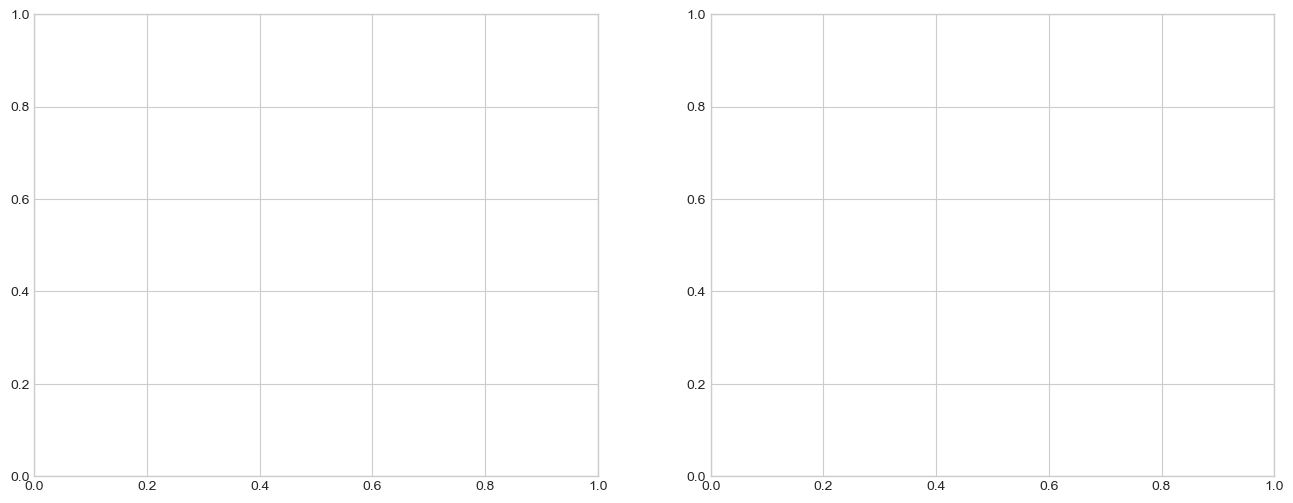

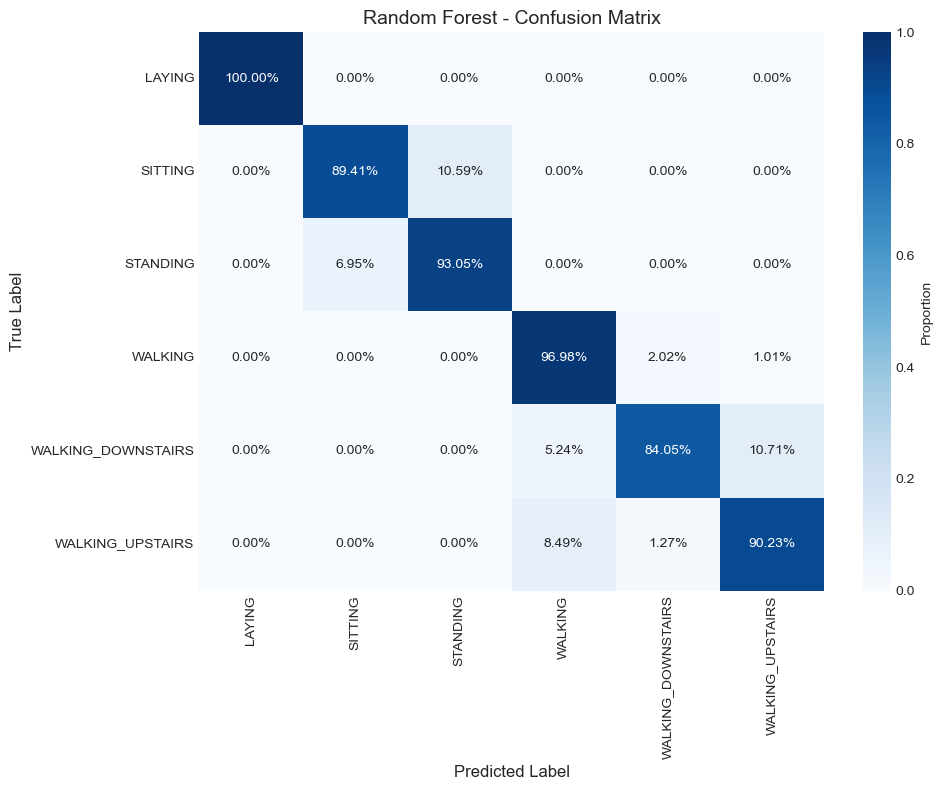

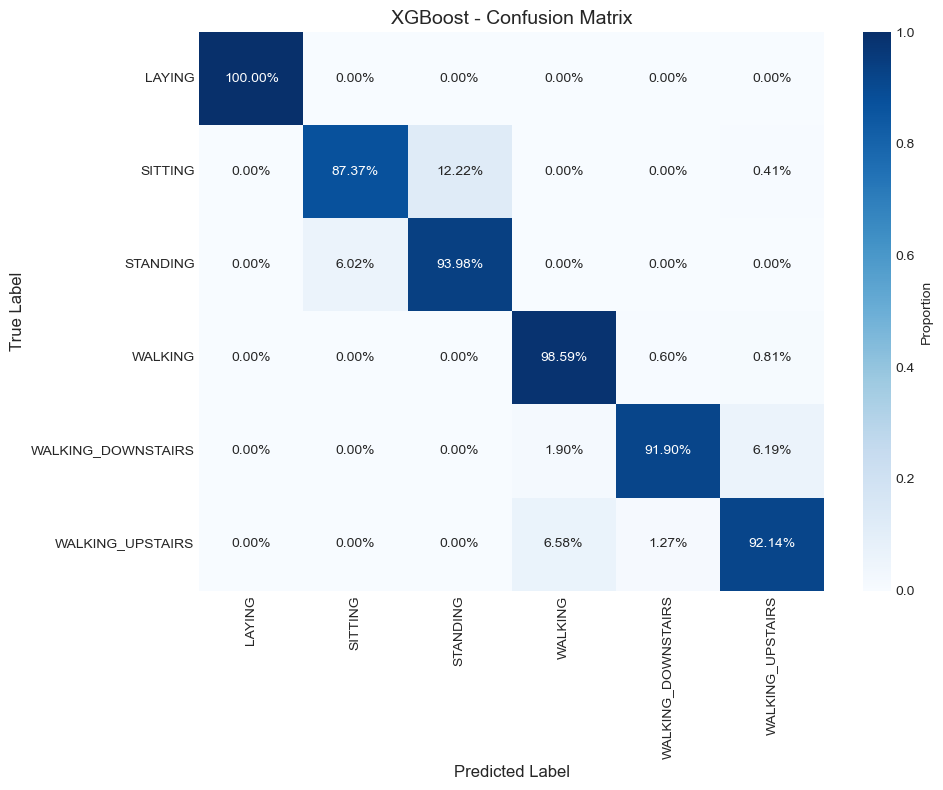

In [12]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
plot_confusion_matrix(
    rf_metrics.confusion_matrix,
    class_names,
    title="Random Forest - Confusion Matrix",
)
plt.savefig(FIGURES_DIR / "confusion_matrix_rf.png", dpi=150, bbox_inches="tight")
plt.show()

# XGBoost
plot_confusion_matrix(
    xgb_metrics.confusion_matrix,
    class_names,
    title="XGBoost - Confusion Matrix",
)
plt.savefig(FIGURES_DIR / "confusion_matrix_xgb.png", dpi=150, bbox_inches="tight")
plt.show()

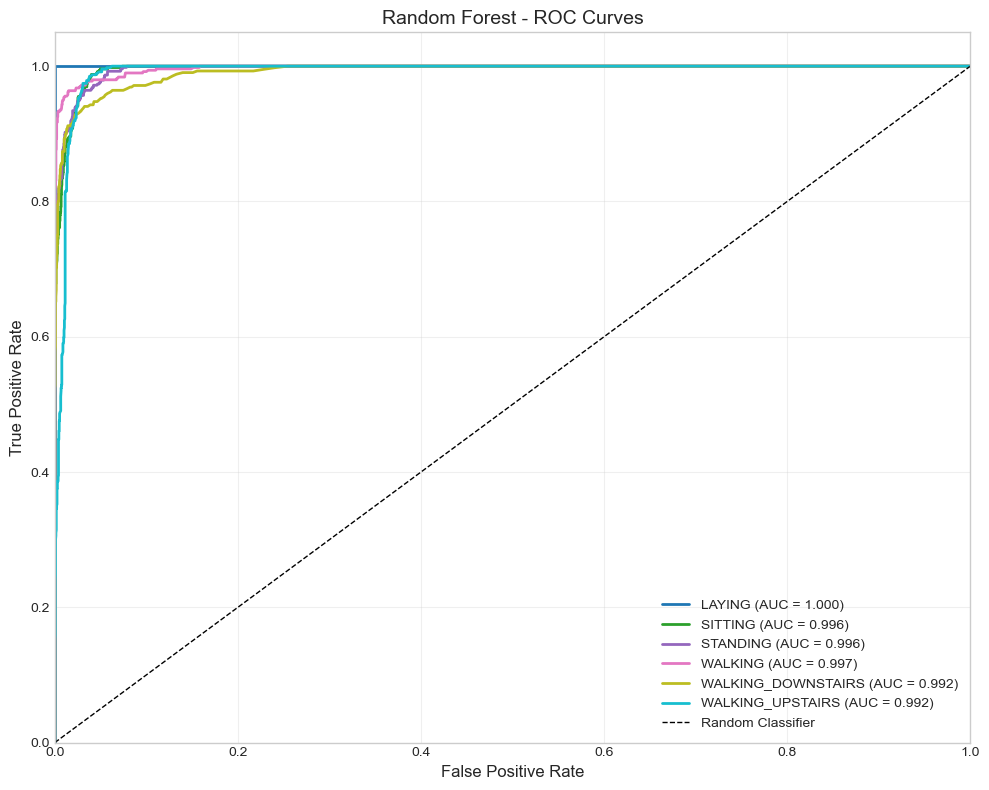

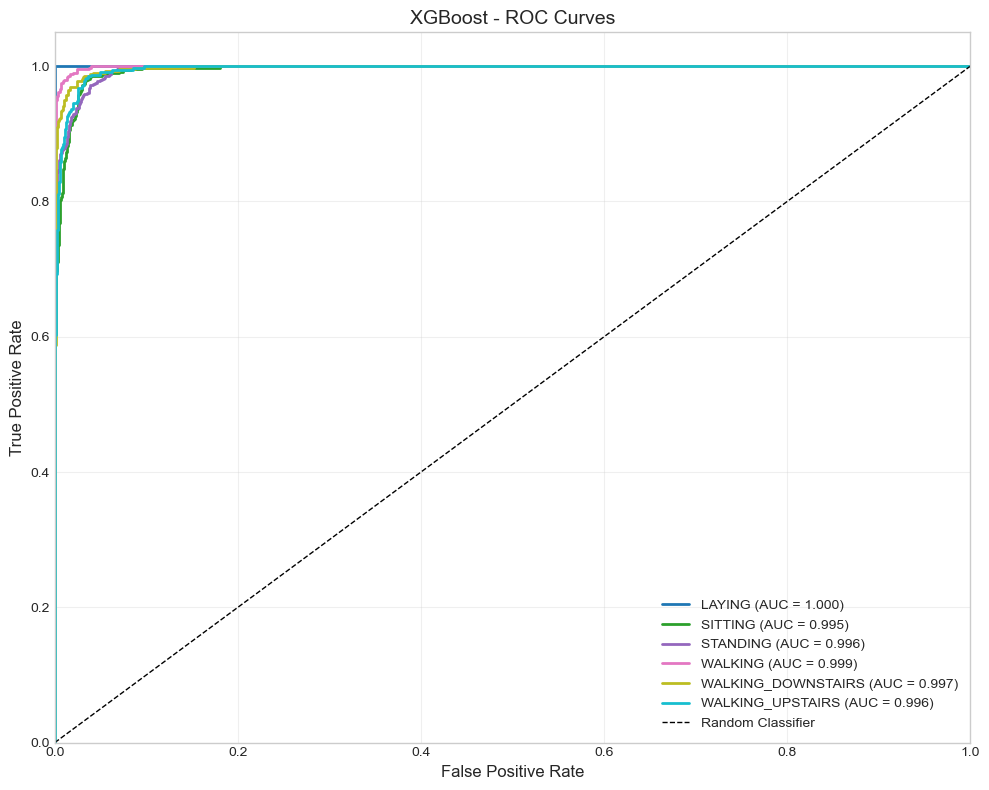

In [13]:
# ROC Curves
y_proba_rf = rf_tuned_result.model.predict_proba(X_test)
y_proba_xgb = xgb_tuned_result.model.predict_proba(X_test)

plot_roc_curves(y_test, y_proba_rf, class_names, title="Random Forest - ROC Curves")
plt.savefig(FIGURES_DIR / "roc_curves_rf.png", dpi=150, bbox_inches="tight")
plt.show()

plot_roc_curves(y_test, y_proba_xgb, class_names, title="XGBoost - ROC Curves")
plt.savefig(FIGURES_DIR / "roc_curves_xgb.png", dpi=150, bbox_inches="tight")
plt.show()

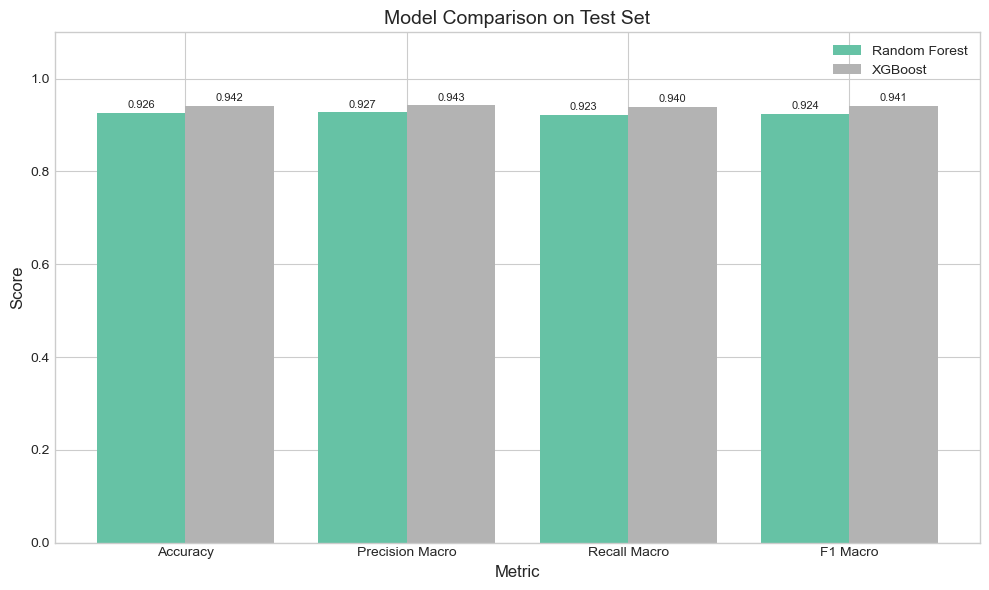

In [14]:
# Model comparison
plot_model_comparison(
    {"Random Forest": rf_metrics, "XGBoost": xgb_metrics},
    metric_names=["accuracy", "precision_macro", "recall_macro", "f1_macro"],
    title="Model Comparison on Test Set",
)
plt.savefig(FIGURES_DIR / "model_comparison_classical.png", dpi=150, bbox_inches="tight")
plt.show()

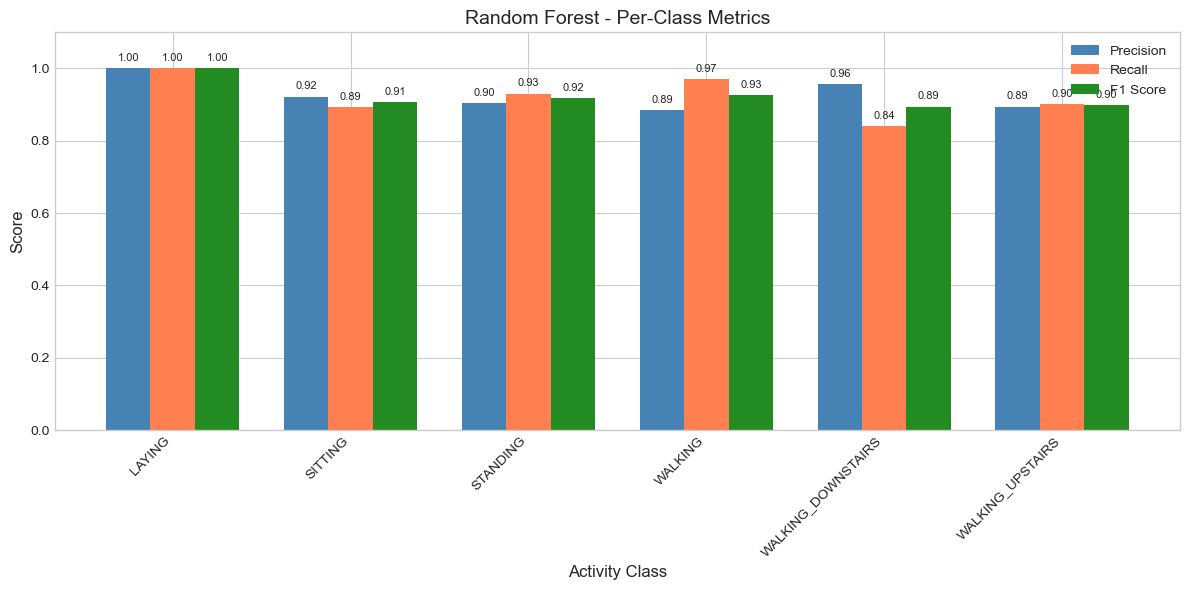

In [15]:
# Per-class metrics
plot_precision_recall_per_class(
    rf_metrics,
    class_names,
    title="Random Forest - Per-Class Metrics",
)
plt.savefig(FIGURES_DIR / "per_class_metrics_rf.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Feature Importance Analysis

In [16]:
# Top features from Random Forest
feature_names = train_data.X.columns.tolist()
top_features_rf = get_top_features(
    rf_tuned_result.feature_importances,
    feature_names,
    n_top=20,
)

print("Top 20 Features (Random Forest):")
for name, importance in top_features_rf:
    print(f"  {name}: {importance:.4f}")

Top 20 Features (Random Forest):
  tGravityAcc-min()-X: 0.0274
  tGravityAcc-mean()-Y: 0.0267
  tGravityAcc-mean()-X: 0.0260
  angle(X,gravityMean): 0.0241
  tGravityAcc-min()-Y: 0.0229
  tGravityAcc-energy()-X: 0.0211
  tGravityAcc-max()-Y: 0.0211
  angle(Y,gravityMean): 0.0196
  tGravityAcc-max()-X: 0.0180
  tGravityAcc-energy()-Y: 0.0143
  fBodyAccJerk-bandsEnergy()-1,16: 0.0124
  tGravityAccMag-std(): 0.0115
  fBodyAccJerk-mean()-X: 0.0110
  tBodyAccJerk-std()-X: 0.0108
  tGravityAcc-arCoeff()-Z,1: 0.0103
  fBodyAcc-mad()-X: 0.0103
  fBodyAccJerk-bandsEnergy()-1,24: 0.0103
  tGravityAcc-min()-Z: 0.0102
  tBodyAccMag-std(): 0.0100
  fBodyAccMag-std(): 0.0100


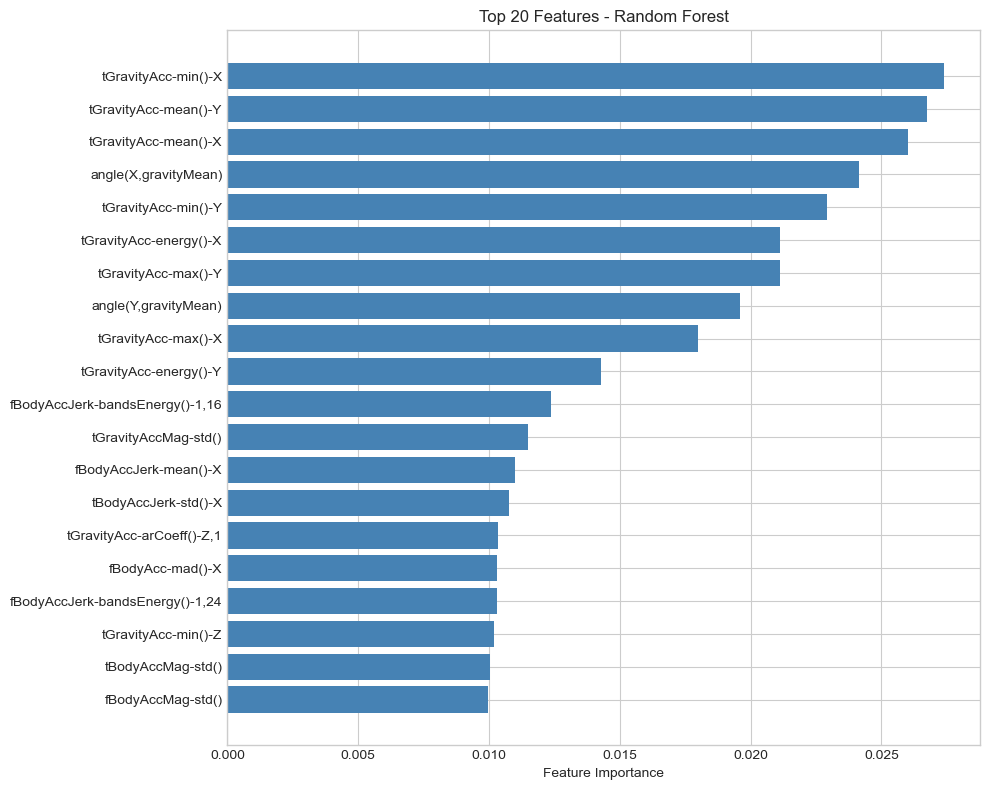

In [17]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))

names, importances = zip(*top_features_rf)
y_pos = np.arange(len(names))

ax.barh(y_pos, importances, color="steelblue")
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()
ax.set_xlabel("Feature Importance")
ax.set_title("Top 20 Features - Random Forest")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "feature_importance_rf.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Summary

### Key Findings:
- Both Random Forest and XGBoost achieve strong performance on the HAR dataset
- The models show high accuracy on static activities (sitting, standing, laying)
- Some confusion exists between similar activities (walking upstairs/downstairs)
- Gravity acceleration and body acceleration features are most predictive

### Next Steps:
- Try deep learning models (LSTM, CNN) for potentially better temporal pattern recognition
- Implement MLflow tracking for experiment management
- Deploy the best model as a REST API

In [18]:
# Save best model info
print("\n" + "="*60)
print("BEST MODEL SUMMARY")
print("="*60)

if rf_metrics.f1_macro >= xgb_metrics.f1_macro:
    print(f"Best model: Random Forest")
    print(f"F1 Score (macro): {rf_metrics.f1_macro:.4f}")
    print(f"Accuracy: {rf_metrics.accuracy:.4f}")
    best_model = rf_tuned_result.model
else:
    print(f"Best model: XGBoost")
    print(f"F1 Score (macro): {xgb_metrics.f1_macro:.4f}")
    print(f"Accuracy: {xgb_metrics.accuracy:.4f}")
    best_model = xgb_tuned_result.model

print("="*60)


BEST MODEL SUMMARY
Best model: XGBoost
F1 Score (macro): 0.9409
Accuracy: 0.9416
